importing the librarries and loading the dataset and making 3d array of 299, 100 , 3 that is 299 samples conatining each 100 rows and 6 cols

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/sensor_data"
FEATURES = ['LinearAccelerationX', 'LinearAccelerationY', 'LinearAccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
MAX_ROWS = 100

def load_dataset(data_dir):
    X, y = [], []
    scaler = StandardScaler()

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        for file in os.listdir(label_path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(label_path, file))[FEATURES]
                df = df.iloc[10:].reset_index(drop=True)  # Trim first 10 rows

                if len(df) < MAX_ROWS:
                    pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
                    df = pd.concat([df, pad], ignore_index=True)
                else:
                    df = df.iloc[:MAX_ROWS]

                df_scaled = scaler.fit_transform(df)
                X.append(df_scaled)
                y.append(label)

    return np.array(X), np.array(y)

X, y = load_dataset(DATA_DIR)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print("✅ Data Loaded:", X.shape, y_onehot.shape)


Mounted at /content/drive
✅ Data Loaded: (299, 100, 6) (299, 3)


building the lstm model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


building the cnn model

In [30]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


flattening the 3d into 2d for random forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Flatten time series to tabular format
X_rf = X.reshape((X.shape[0], -1))  # shape: (samples, time × features)


uses k stratified fold method to find accuraccies across all model

In [38]:
def train_and_evaluate_model(build_fn, model_name, X, y, use_onehot=True):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    acc_scores = []

    for train_idx, val_idx in kf.split(X, y_encoded):
        print(f"\n🔁 {model_name} - Fold {fold}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_raw, y_val_raw = y_encoded[train_idx], y_encoded[val_idx]

        if use_onehot:
            y_train = to_categorical(y_train_raw)
            y_val = to_categorical(y_val_raw)
            model = build_fn(X.shape[1:], y_train.shape[1])
            model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=20, batch_size=32, verbose=0)
            y_pred = np.argmax(model.predict(X_val), axis=1)
        else:
            model = build_fn()
            model.fit(X_train, y_train_raw)
            y_pred = model.predict(X_val)

        acc = accuracy_score(y_val_raw, y_pred)
        acc_scores.append(acc)
        print(f"✅ Accuracy: {acc:.4f}")
        print(classification_report(y_val_raw, y_pred, target_names=label_encoder.classes_))

        cm = confusion_matrix(y_val_raw, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_, cmap='Blues')
        plt.title(f"{model_name} - Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        fold += 1

    print(f"\n📊 {model_name} Average Accuracy: {np.mean(acc_scores):.4f}")



🔁 LSTM - Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       0.95      1.00      0.98        20
         mid       1.00      0.95      0.97        20
       right       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



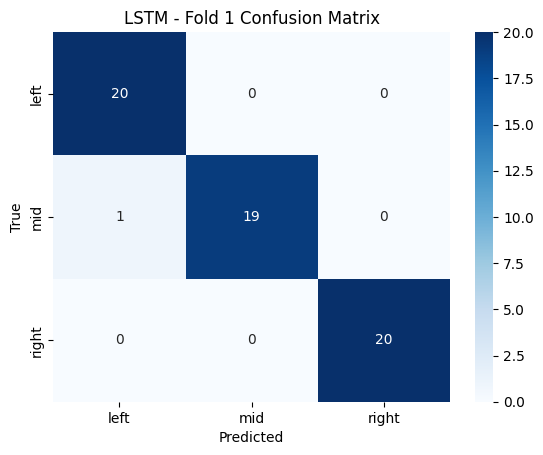


🔁 LSTM - Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       1.00      0.95      0.97        20
         mid       0.95      1.00      0.98        20
       right       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



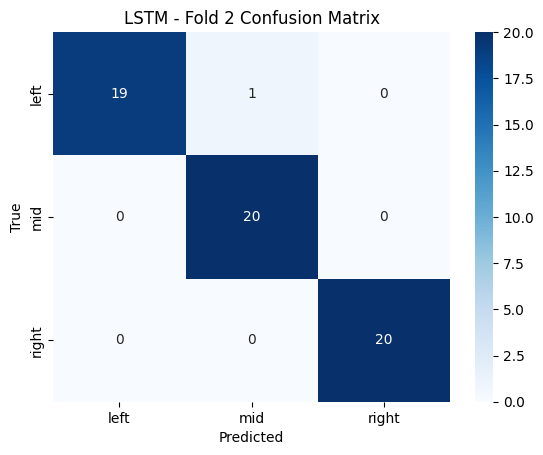


🔁 LSTM - Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
✅ Accuracy: 0.9500
              precision    recall  f1-score   support

        left       0.87      1.00      0.93        20
         mid       1.00      0.85      0.92        20
       right       1.00      1.00      1.00        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



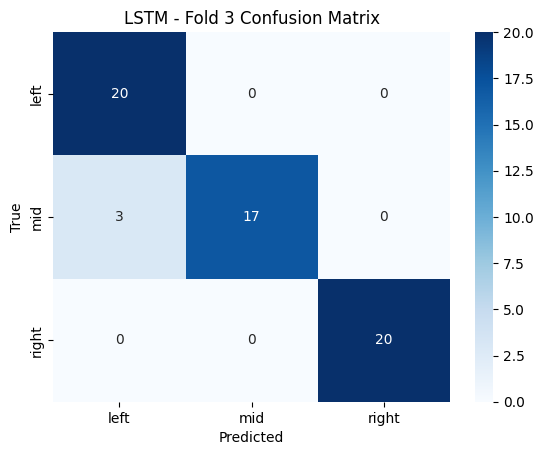


🔁 LSTM - Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       1.00      1.00      1.00        20
         mid       1.00      0.95      0.97        20
       right       0.95      1.00      0.98        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



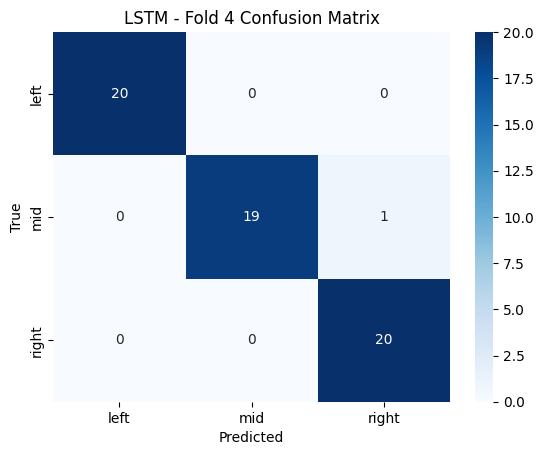


🔁 LSTM - Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
train_and_evaluate_model(build_lstm_model, "LSTM", X, y_onehot)
train_and_evaluate_model(build_cnn_model, "1D-CNN", X, y_onehot)

# Random Forest uses flattened input
train_and_evaluate_model(
    build_fn=lambda: RandomForestClassifier(n_estimators=100),
    model_name="Random Forest",
    X=X_rf,
    y=y_encoded,
    use_onehot=False
)


In [35]:
# code to test the models
def predict_csv(file_path, model, model_type='lstm'):
    df = pd.read_csv(file_path)[FEATURES]
    df = df.iloc[10:].reset_index(drop=True)

    if len(df) < MAX_ROWS:
        pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
        df = pd.concat([df, pad], ignore_index=True)
    else:
        df = df.iloc[:MAX_ROWS]

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    if model_type == 'rf':
        X_input = df_scaled.reshape(1, -1)
        pred = model.predict(X_input)
    else:
        X_input = np.expand_dims(df_scaled, axis=0)
        pred = np.argmax(model.predict(X_input), axis=1)

    label = label_encoder.inverse_transform(pred)[0]
    print(f"{os.path.basename(file_path)} ➜ {label}")


In [36]:
predict_csv("content/drive/MyDrive/test_data", build_lstm_model())

TypeError: build_lstm_model() missing 2 required positional arguments: 'input_shape' and 'num_classes'